In [1]:
import glob
from opendrift.models import oceandrift
from opendrift.readers import reader_NEMO_native, reader_netCDF_CF_irregular2D

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import datetime
import cartopy.crs as ccrs
import pandas as pd

In [2]:
def make_circle_of_points(lon, lat, diff_deg, num=20):
    lons = np.linspace(lon - diff_deg, lon + diff_deg,num=num)
    lats = np.linspace(lat - diff_deg, lat + diff_deg,num=num)
    lons, lats = np.meshgrid(lons, lats)
    # Remove points outside of radisu
    inds = np.where(np.sqrt((lons-lon)**2 + (lats-lat)**2) > diff_deg)
    lons[inds] = np.nan
    lats[inds] = np.nan
    lons = lons.flatten()[~np.isnan(lons.flatten())]
    lats = lats.flatten()[~np.isnan(lats.flatten())]
    return lons, lats

In [3]:
def make_perimeter_of_points(lon, lat, diff_deg, num=20):
    thetas = np.linspace(0, 2*np.pi, num=num)
    lons = [lon + diff_deg*np.cos(theta) for theta in thetas]
    lats = [lat + diff_deg*np.sin(theta) for theta in thetas]
    return lons, lats

In [4]:
diff_deg = 0.1
num=20

# Where strike occured
strike_lon = -63.0617 
strike_lat =  44.625
strike_date = datetime.datetime(2024,4,18) # 11:20am - not sure time zone

# Where sighting occured
sight_lon = -65.05138889
sight_lat = 42.19694444
sight_date = datetime.datetime(2024, 5, 13) #sighting on May 2 but not sure what time so project to May 13

strike_lons, strike_lats = make_circle_of_points(strike_lon, strike_lat, diff_deg,num=num)
strike_perim_lons, strike_perim_lats = make_perimeter_of_points(strike_lon, strike_lat, diff_deg,num=num)

sight_lons, sight_lats = make_circle_of_points(sight_lon, sight_lat, diff_deg,num=num)
sight_perim_lons, sight_perim_lats = make_perimeter_of_points(sight_lon, sight_lat, diff_deg,num=num)

duration = sight_date - strike_date

In [5]:
ocean = '/home/nso001/data/work7/OPP/whale-drift/scotian-shelf2024/data/ciopse/*.nc'
mesh='/home/sdfo600/gpfs7/CONSTANTS/CIOPS-E_v2.0.0/mesh_mask.nc'
rotation_pickle='/home/nso001/data/work7/rotation_pickles/ciopsev2/ciopsev2.rotation.pickle'
ocean_files = glob.glob(ocean)
ocean_files.sort()
mapping = {'vos': 'y_sea_water_velocity',
           'uos': 'x_sea_water_velocity',
           'time_counter': 'time',
           'nav_lon': 'longitude',
           'nav_lat': 'latitude'}
reader_ocean = reader_NEMO_native.Reader(ocean_files, meshfile=mesh, 
                                         variable_mapping=mapping,
                                         rotation_pickle_file=rotation_pickle )

In [6]:
reader_ocean.land_binary_mask

<xarray.Variable (y: 945, x: 1410)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [7]:
hrdps = '/home/nso001/data/work7/OPP/whale-drift/scotian-shelf2024/data/hrdps/*.nc'
hrdps_files = glob.glob(hrdps)
hrdps_files.sort()
atmos_variable_mapping = {'u_wind': 'x_wind',
                          'v_wind': 'y_wind',
                          'time_counter': 'time',
                          'nav_lon': 'longitude',
                          'nav_lat': 'latitude'}


reader_atmos = reader_netCDF_CF_irregular2D.Reader(hrdps_files, variable_mapping=atmos_variable_mapping,)

In [8]:
o = oceandrift.OceanDrift(loglevel=20, seed=None)

22:34:09 INFO    opendrift.models.basemodel:539: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-119-gfb02202)


In [9]:
#o.add_reader([reader_land])
o.max_speed=5
o.add_reader([reader_ocean, reader_atmos])
o.set_config('drift:advection_scheme', 'runge-kutta4')
o.set_config('general:coastline_action', 'stranding')
o.set_config('seed:ocean_only', False)
o.set_config('general:use_auto_landmask', False)

In [10]:
o.seed_elements(lon=strike_lons,
                lat=strike_lats,
                z=0,
                time=strike_date,
                wind_drift_factor=0.03)


In [11]:
outfile="opendrift-ciopsehrdps-windage0.03-initialtest.nc"

In [12]:
o.run(time_step=900,
      time_step_output=21600,
      steps=int(duration.total_seconds()/900),
      outfile=outfile)

22:34:09 INFO    opendrift.models.basemodel:2591: Fallback values will be used for the following variables which have no readers: 
22:34:09 INFO    opendrift.models.basemodel:2594: 	upward_sea_water_velocity: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	ocean_vertical_diffusivity: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_significant_height: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
22:34:09 INFO    opendrift.models.basemodel:2594: 	surface_downward_x_stress: 0.000000
22:34:09 INFO    opendrift.models.basem

In [13]:
ds = xr.open_dataset(outfile)

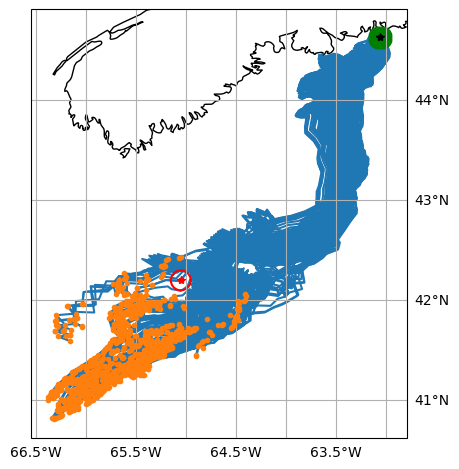

In [14]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
#ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), color='C0')
#ds.plot.scatter(x='lon',y='lat',hue='time',  ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,add_legend=False,s=5,edgecolors='face')
#ds.isel(obs=0).plot.scatter(x='lon',y='lat',color='g',transform=ccrs.PlateCarree())
dend=ds.where((pd.to_datetime(ds.time.values)>=sight_date -datetime.timedelta(days=1))
             & (pd.to_datetime(ds.time.values) <=sight_date))
for t in ds.trajectory.values:
    d=ds.sel(trajectory=t)
    dend_t = dend.sel(trajectory=t)
    lons = np.ma.masked_greater(d.lon.values, 360)
    lats = np.ma.masked_greater(d.lat.values, 360)
    lons_sd = np.ma.masked_greater(dend_t.lon.values,360)
    lats_sd = np.ma.masked_greater(dend_t.lat.values,360)
    ax.plot(lons[~np.isnan(lons)], lats[~np.isnan(lats)], 'C0', transform=ccrs.PlateCarree())
    #ax.plot(lons[~np.isnan(lons)][-1], lats[~np.isnan(lats)][-1], '.C1', transform=ccrs.PlateCarree())
    if np.any(~np.isnan(lons_sd)):
        ax.plot(lons_sd[~np.isnan(lons_sd)], lats_sd[~np.isnan(lats_sd)], '.C1', transform=ccrs.PlateCarree(),zorder=10)
ax.gridlines(draw_labels=['bottom', 'right'])
ax.coastlines()

ax.plot(strike_lons,strike_lats, 'g.', transform=ccrs.PlateCarree())
ax.plot(strike_lon, strike_lat, 'k*', transform=ccrs.PlateCarree())
ax.plot(sight_perim_lons, sight_perim_lats, 'r-', transform=ccrs.PlateCarree())
ax.plot(sight_lon, sight_lat,
        'r*', transform=ccrs.PlateCarree())

## Backward

In [15]:
o2 = oceandrift.OceanDrift(loglevel=20, seed=None)
o2.max_speed=5
#o2.add_reader([reader_land])
o2.add_reader([reader_ocean, reader_atmos])
o2.set_config('drift:advection_scheme', 'runge-kutta4')
o2.set_config('general:coastline_action', 'stranding')
o2.set_config('seed:ocean_only', False)
o2.set_config('general:use_auto_landmask', False)

22:55:52 INFO    opendrift.models.basemodel:539: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-119-gfb02202)


In [16]:
o2.seed_elements(lon=sight_lons,
                 lat=sight_lats,
                 z=0,
                 time=sight_date,
                 wind_drift_factor=0.03)

In [17]:
outfile='opendrift-initialtest-ciopsehrdps-windage0.03-backward.nc'

In [18]:
o2.run(time_step=-900,
      time_step_output=21600,
      steps=int(duration.total_seconds()/900),
      outfile=outfile)

22:55:52 INFO    opendrift.models.basemodel:2591: Fallback values will be used for the following variables which have no readers: 
22:55:52 INFO    opendrift.models.basemodel:2594: 	upward_sea_water_velocity: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	ocean_vertical_diffusivity: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_significant_height: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
22:55:52 INFO    opendrift.models.basemodel:2594: 	surface_downward_x_stress: 0.000000
22:55:52 INFO    opendrift.models.basem

In [19]:
ds = xr.open_dataset(outfile)

(41.5, 45.0)

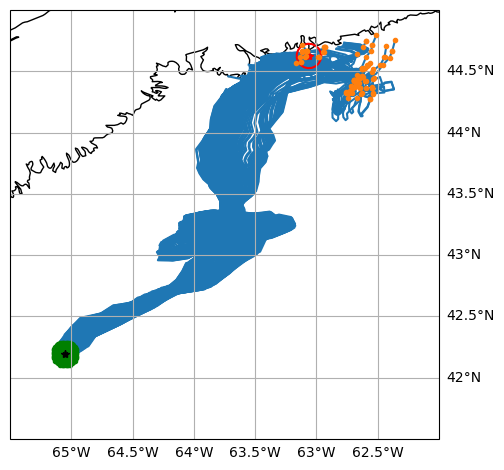

In [20]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
#ax.plot(np.ma.masked_invalid(ds['lon'].values.T), np.ma.masked_invalid(ds['lat'].values.T), transform=ccrs.PlateCarree(),color='C0')
#ds.plot.scatter(x='lon',y='lat',hue='time',  ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,add_legend=False,s=5,edgecolors='face')
#ds.isel(obs=0).plot.scatter(x='lon',y='lat',color='g',transform=ccrs.PlateCarree())
dend=ds.where((pd.to_datetime(ds.time.values)>=strike_date) & 
                  (pd.to_datetime(ds.time.values) <=strike_date +datetime.timedelta(days=1)))
for t in ds.trajectory.values:
    d=ds.sel(trajectory=t)
    dend_t  = dend.sel(trajectory=t)
    lons = np.ma.masked_greater(d.lon.values, 360)
    lats = np.ma.masked_greater(d.lat.values, 360)
    lons_sd = np.ma.masked_greater(dend_t.lon.values,360)
    lats_sd = np.ma.masked_greater(dend_t.lat.values,360)
    ax.plot(lons[~np.isnan(lons)], lats[~np.isnan(lats)], 'C0', transform=ccrs.PlateCarree())
    #ax.plot(lons[~np.isnan(lons)][-1], lats[~np.isnan(lats)][-1], '.C1', transform=ccrs.PlateCarree())
    if np.any(~np.isnan(lons_sd)):
        ax.plot(lons_sd[~np.isnan(lons_sd)], lats_sd[~np.isnan(lats_sd)], '.C1', transform=ccrs.PlateCarree(),zorder=10)
ax.gridlines(draw_labels=['bottom', 'right'])
ax.coastlines()
ax.plot(sight_lons, sight_lats, 'g.', transform=ccrs.PlateCarree())
ax.plot(sight_lon, sight_lat, 'k*', transform=ccrs.PlateCarree())
ax.plot(strike_perim_lons, strike_perim_lats, 'r-', transform=ccrs.PlateCarree())
ax.plot(strike_lon, strike_lat,
        'r*', transform=ccrs.PlateCarree())
ax.set_xlim([-65.5, -62])
ax.set_ylim([41.5,45])